----
----
# <b> </b>
# <b><center> Imagerie fonctionelle cérébrale </center></b>
# <b><center> Matteo Marengo || matteo.marengo@ens-paris-saclay.fr</center></b>


----
----
# <b>M/EEG exam instructions</b>
- Assignment format:
    - mandatory: a notebook with your answers
    - optional: an additional document with your answers to the conceptual questions
- Please send your assignment to M.Corsi's email address
- Deadline:
    - **Feb 22nd, 8AM.** Please not that an **extension will not be proposed.**

- **DISCLAIMER**: The answers of the questions can be found in the report and not directly in the notebook
----
----

In [1]:
# Comment if you do not use google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <b>Import Libraries</b>

In [2]:
# Install these libraries
!pip install mne
!pip install mne_connectivity
!pip install fastapi
!pip install kaleido
!pip install uvicorn
!pip install python-multipart
!pip install pyriemann
!pip install moabb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.5 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2023.7.0
    Uninstalling xarray-2023.7.0:
      Successfully uninstalled xarray-2023.7.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# %matplotlib qt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper

from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle


----
----
# <b>Part 1 - Connectivity and Networks</b>

Here is an EEG dataset to load:
- Here is the link to the <a href="https://mne.tools/dev/generated/mne.datasets.eegbci.load_data.html"> EEG dataset that is loaded</a>

Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 17s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T

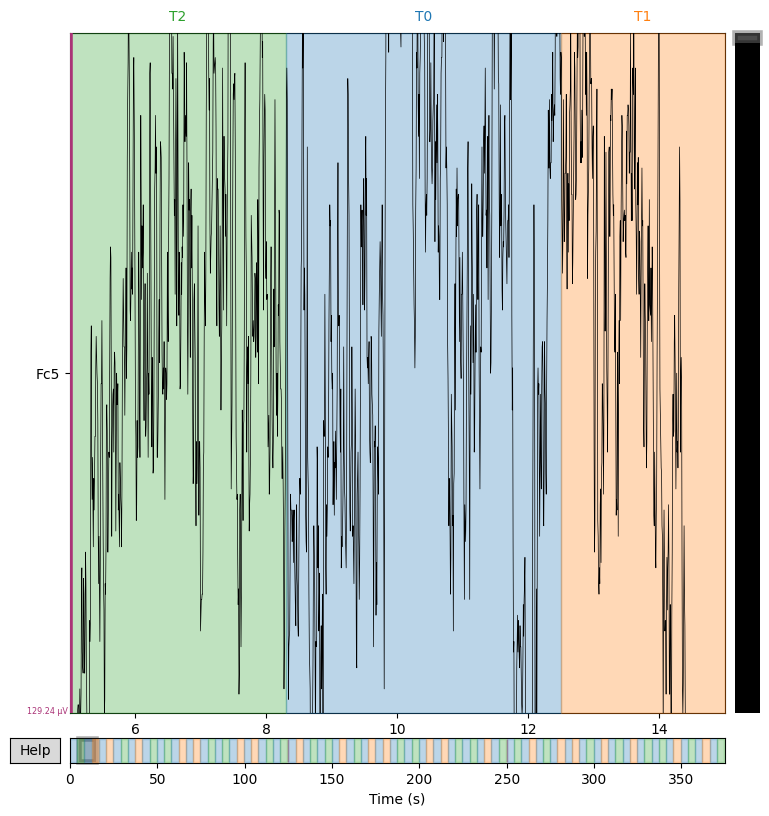

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-4-bc82fcd1e375>:28: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin=0, fmax=40, picks=channel_to_plot)  # Updated fmax value to be 40


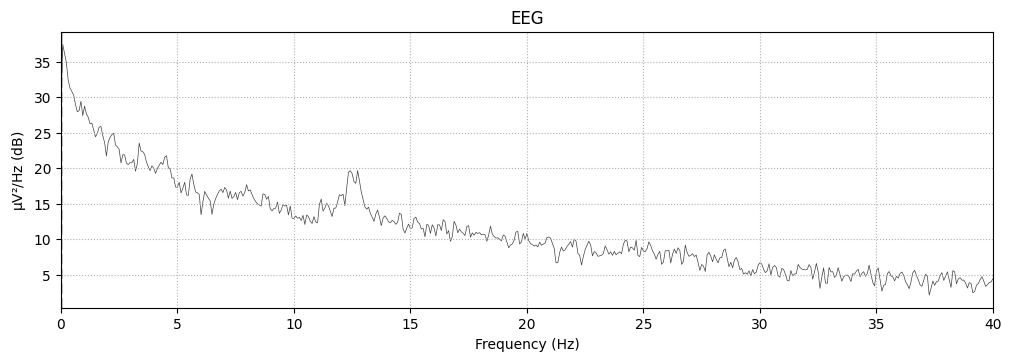

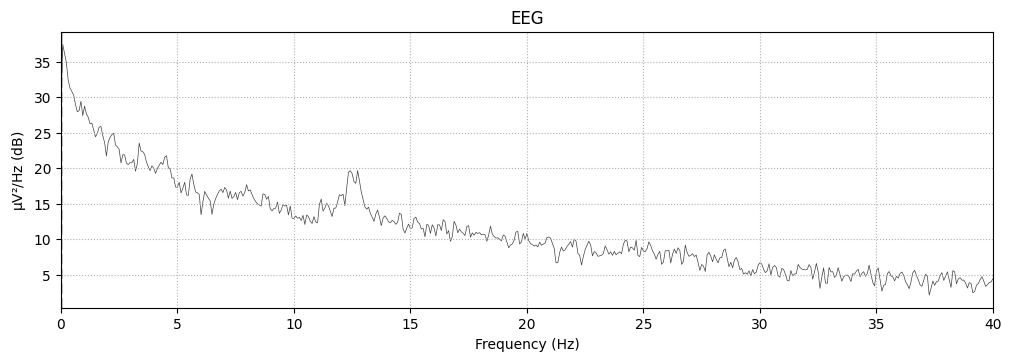

In [4]:
# Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # Motor imagery: hands vs feet

# Extract raw data
fnames = eegbci.load_data(subject=subject, runs=runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])
raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names
events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))
channel_names = raw.info['ch_names']

# Extract trials between -1s and 4s
tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks
epochs = mne.Epochs(
    raw,
    events,
    event_ids,
    tmin - 0.5,
    tmax + 0.5,
    baseline=None,
    preload=True,
)

# Plot one channel of the raw data
channel_to_plot = 'Fc5'
raw.plot(n_channels=1, start=5, duration=10, scalings='auto', title=channel_to_plot)
raw.plot_psd(fmin=0, fmax=40, picks=channel_to_plot)


----
## <b>Questions:</b>
- For each condition:
    - Compute and plot the connectivity matrices based on the estimation of the imaginary coherence averaged over the mu band and across the epochs.
      - What does it say about potential changes between the tasks performed by the subject?
      - Adapted from <a href = "https://github.com/mccorsi/M2-MVA_MEEG_hands-on_materials/blob/main/Lesson3_AdvancedAnalysis/ConnectivitySourceSpace.ipynb" > the teacher's GitHub </a>
    - Compute and plot the associated node strength averaged across the epochs.
      - What does it say about potential changes between the tasks performed by the subject?

- Here is the plot of the statistical difference between MI and Rest conditions obtained from imaginary coherence (left) and the results obtained with the node strength (right):
- What do you observe? Is it neurophysiologically meaningful?
  
![Figure_ImCoh](./MI_Rest_ImCoh.png)


Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=-1.500s..4.500s for estimation (961 points)
    frequencies: 8.2Hz..13.0Hz (30 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectr

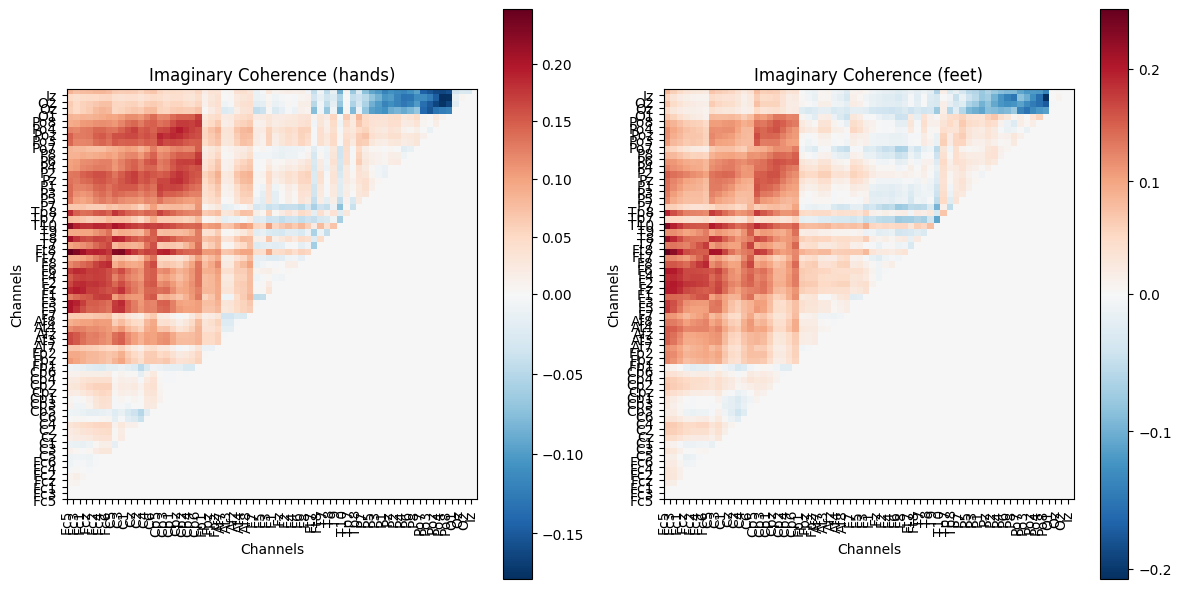

In [5]:
# Task 1

################################
# DEFINITION
# Define the mu band
fmin, fmax = 8., 13.
sfreq = raw.info['sfreq']  # sampling frequency

# Define the two conditions (hands & feet)
conditions = ['hands', 'feet']
matrices_of_con = {}

################################
# CALCUTE CONNECTIVITY MATRICES
for condition in conditions:
    epochs_cond = epochs[condition]

    con = spectral_connectivity_epochs(
        epochs_cond, method='imcoh', mode='multitaper', sfreq=sfreq, fmin=fmin, fmax=fmax,
        faverage=True, mt_adaptive=True, n_jobs=1)

    # Access the imaginary coherence values
    con_data = con.get_data(output='dense')
    matrices_of_con[condition] = np.mean(con_data, axis=2)  

################################
# PLOT
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, condition in enumerate(conditions):
    ax = axes[i]
    im = ax.imshow(matrices_of_con[condition], cmap='RdBu_r', origin='lower',
                   extent=[0, len(channel_names), 0, len(channel_names)],
                   norm=TwoSlopeNorm(vcenter=0))
    ax.set_title(f'Imaginary Coherence ({condition})')
    ax.set_xlabel('Channels')
    ax.set_ylabel('Channels')
    ax.set_xticks(np.arange(len(channel_names)))
    ax.set_xticklabels(channel_names, rotation=90)
    ax.set_yticks(np.arange(len(channel_names)))
    ax.set_yticklabels(channel_names)

    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=-1.500s..4.500s for estimation (961 points)
    frequencies: 8.2Hz..13.0Hz (30 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectr

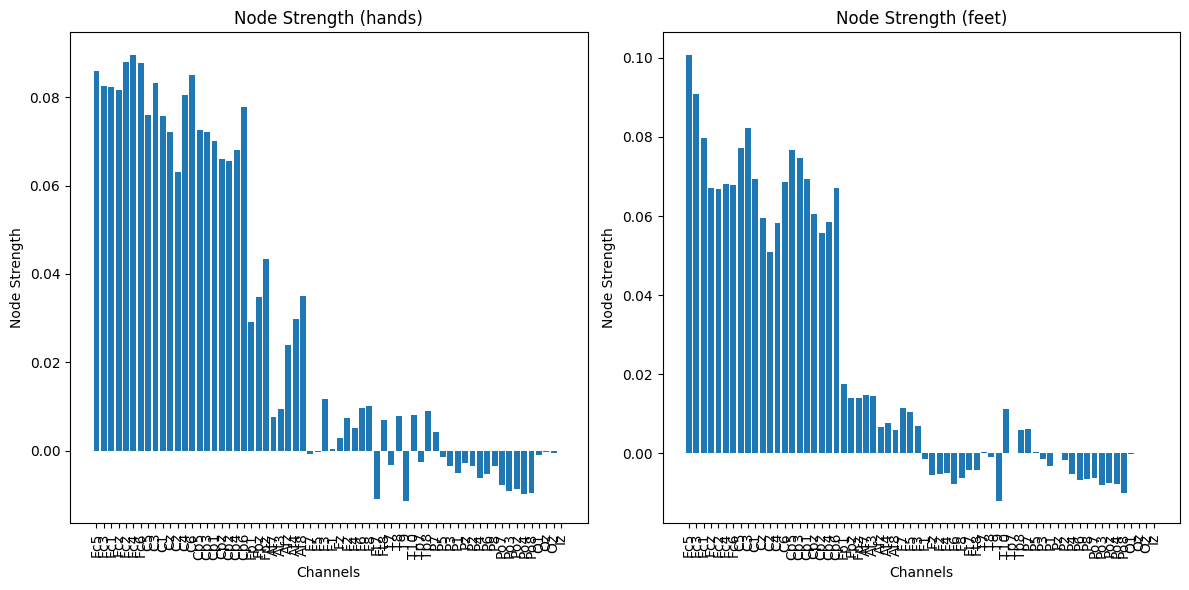

In [6]:
# Parameters for the mu band
fmin, fmax = 8., 13.
sfreq = raw.info['sfreq']

# Compute connectivity for each condition
conditions = ['hands', 'feet']
node_strengths = {}

for condition in conditions:
    epochs_cond = epochs[condition]
    con = spectral_connectivity_epochs(
        epochs_cond, method='imcoh', mode='multitaper', sfreq=sfreq, fmin=fmin, fmax=fmax,
        faverage=True, mt_adaptive=True, n_jobs=1)

    con_data = con.get_data(output='dense')
    node_strength = np.mean(np.sum(con_data, axis=2), axis=0)
    node_strengths[condition] = node_strength

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, condition in enumerate(conditions):
    ax = axes[i]
    bars = ax.bar(np.arange(len(channel_names)), node_strengths[condition])
    ax.set_title(f'Node Strength ({condition})')
    ax.set_xlabel('Channels')
    ax.set_ylabel('Node Strength')
    ax.set_xticks(np.arange(len(channel_names)))
    ax.set_xticklabels(channel_names, rotation=90)

plt.tight_layout()
plt.show()


----
----
# <b>Part 2 - Features in BCI</b>

Here is an EEG dataset to load:

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 961 original time points ...
0 bad epochs dropped
Not setting metadata
Apply

  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.724718
stat_fun(H1): min=-4.138024 max=3.447988
Running initial clustering …
Found 98 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.724718
stat_fun(H1): min=-8.552076 max=3.438133
Running initial clustering …
Found 113 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.724718
stat_fun(H1): min=-8.552076 max=3.438133
Running initial clustering …
Found 87 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.724718
stat_fun(H1): min=-6.323372 max=5.715372
Running initial clustering …
Found 149 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.724718
stat_fun(H1): min=-6.323372 max=5.715372
Running initial clustering …
Found 77 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


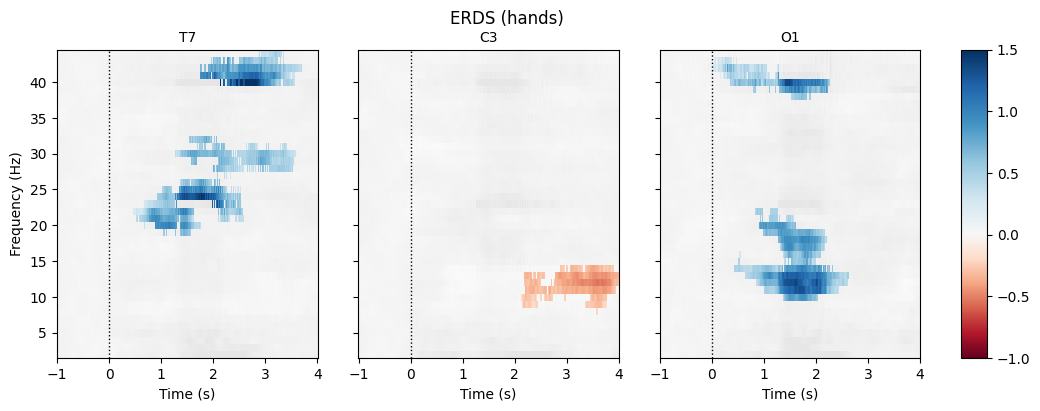

Using a threshold of 1.713872
stat_fun(H1): min=-5.649621 max=3.069908
Running initial clustering …
Found 63 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.713872
stat_fun(H1): min=-5.649621 max=3.069908
Running initial clustering …
Found 80 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.713872
stat_fun(H1): min=-3.754759 max=3.360704
Running initial clustering …
Found 116 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.713872
stat_fun(H1): min=-3.754759 max=3.360704
Running initial clustering …
Found 113 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.713872
stat_fun(H1): min=-3.616018 max=3.513905
Running initial clustering …
Found 134 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.713872
stat_fun(H1): min=-3.616018 max=3.513905
Running initial clustering …
Found 60 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


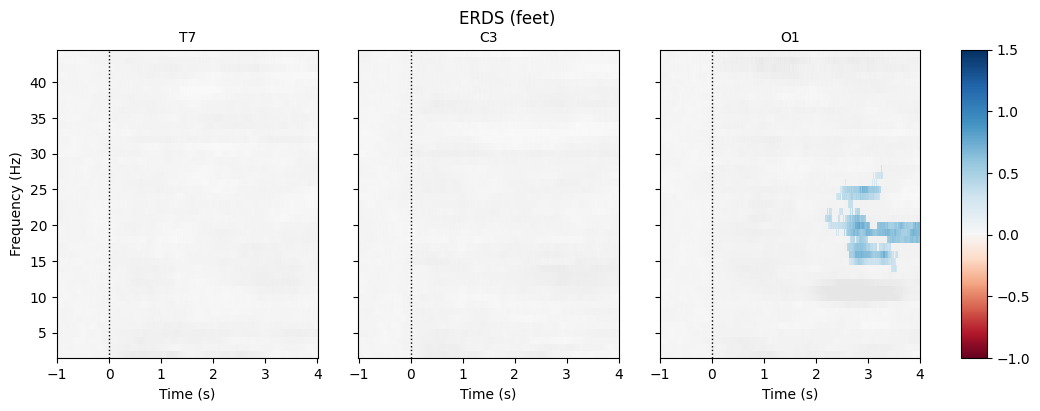

In [7]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # Motor imagery: hands vs feet

# Extract raw data
fnames = eegbci.load_data(subject=subject, runs=runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])
raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names
events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

# Extract trials between -1s and 4s
channelsOfInterest = "T7", "C3", 'O1' # to get the full list of channels you can type: raw.info['ch_names']
tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks
epochs = mne.Epochs(
    raw,
    events,
    event_ids,
    tmin - 0.5,
    tmax + 0.5,
    picks=(channelsOfInterest),
    baseline=None,
    preload=True,
)

# Compare power spectra computed in each condition/channel
freqs = np.arange(2, 45)
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

# Time-Frequency decomposition
tfr = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

nb_channels = len(channelsOfInterest)
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

------
## <b>Questions:</b>
- Please describe the observations you can make from the maps. Are there neurophysiologically relevant/meaningful?
- To what extent such observations are informative of BCI performance?
- If you were the experimenter, based on the previous observations, which (electrode(s); frequency bin(s)) couples would you pick to extract the features? Why?

----
----
# <b>Part 3 - Machine Learning & BCI</b>

## <b>Context</b>

- Here is a publicly available [BCI dataset](http://moabb.neurotechx.com/docs/generated/moabb.datasets.BNCI2014_001.html#moabb.datasets.BNCI2014_001) (cf below to load the data and to get information regarding the experimental information).
- In the following lines of code we defined two classification pipelines **(CSP+LDA: Common Spatial Patterns + LDA, RG+LR: Riemannian Geometry + Logistic Regression)**, and we plotted their performances from a dataset composed of 2 subjects.

----
## <b>Questions</b>
- What observations can be made from the plots?
- Instead of those implemented here, what framework would you propose to extract, select, and classify the features? Why? How would you assess the performance of your approach?

----
## <b>BONUS</b>
- Implement below your framework and compare it to the other pipelines (namely RG+LR and CSP+LDA).
- What are your conclusions? Do you have some suggestion(s) to improve the performance of your framework?

In [8]:
import warnings

from mne.decoding import CSP
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")
warnings.filterwarnings("ignore")


###### PIPELINES TO BE COMPARED (do not modify it!) ######
# baseline pipeline to be used to make the comparison, please complete the following line with your framework
pipelines = {}
pipelines["CSP+LDA"] = make_pipeline(CSP(n_components=8), LDA())
pipelines["RG+LR"] = make_pipeline(
    Covariances(), TangentSpace(), LogisticRegression(solver="lbfgs")
)
### BONUS - implementation of your framework ######
#pipelines["MyPipeline"] =
from sklearn.svm import SVC

pipelines["CSP+SVM"] = make_pipeline(CSP(n_components=8), SVC())

from sklearn.covariance import LedoitWolf
from sklearn.ensemble import RandomForestClassifier

pipelines["LW+RF"] = make_pipeline(
    Covariances(estimator='lwf'),
    TangentSpace(),
    RandomForestClassifier()
)



###### DATASET TO BE USED (do not modify it!) - downloading it the first time can take some time ######
dataset = BNCI2014_001()
subj = [1, 2]
dataset.subject_list = subj


###### DEFINITION OF THE PARADIGM & EVALUATION (do not modify it!) ######
paradigm = LeftRightImagery()
evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=dataset, overwrite=False
)
results = evaluation.process(pipelines)
print(results.head()) # if you want to look at it...


<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/usr/local/lib/python3.10/dist-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


BNCI2014-001-WithinSession:   0%|          | 0/2 [00:00<?, ?it/s]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A01T.mat' to file '/root/mne_data/MNE-bnci-data/database/data-sets/001-2014/A01T.mat'.


MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location



  0%|                                              | 0.00/42.8M [00:00<?, ?B/s]
  0%|                                     | 8.19k/42.8M [00:00<10:28, 68.1kB/s]
  0%|                                      | 32.8k/42.8M [00:00<05:00, 143kB/s]
  0%|                                      | 88.1k/42.8M [00:00<02:34, 276kB/s]
  0%|▏                                      | 161k/42.8M [00:00<01:48, 391kB/s]
  1%|▎                                      | 337k/42.8M [00:00<00:56, 747kB/s]
  2%|▌                                     | 696k/42.8M [00:00<00:29, 1.45MB/s]
  3%|█▏                                   | 1.42M/42.8M [00:00<00:14, 2.83MB/s]
  6%|██▏                                  | 2.54M/42.8M [00:01<00:08, 4.69MB/s]
 11%|████                                 | 4.66M/42.8M [00:01<00:04, 8.39MB/s]
 16%|██████                               | 6.96M/42.8M [00:01<00:03, 11.3MB/s]
 22%|███████▉                             | 9.22M/42.8M [00:01<00:02, 13.3MB/s]
 27%|█████████▉                        

No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.


BNCI2014-001-WithinSession:  50%|█████     | 1/2 [00:34<00:34, 34.66s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A02T.mat' to file '/root/mne_data/MNE-bnci-data/database/data-sets/001-2014/A02T.mat'.

  0%|                                              | 0.00/43.1M [00:00<?, ?B/s]
  0%|                                     | 8.19k/43.1M [00:00<10:23, 69.1kB/s]
  0%|                                      | 32.8k/43.1M [00:00<04:59, 143kB/s]
  0%|                                      | 88.1k/43.1M [00:00<02:35, 277kB/s]
  0%|▏                                      | 193k/43.1M [00:00<01:27, 491kB/s]
  1%|▎                                      | 409k/43.1M [00:00<00:46, 924kB/s]
  2%|▋                                     | 833k/43.1M [00:00<00:24, 1.74MB/s]
  4%|█▍                                   | 1.69M/43.1M [00:00<00:12, 3.36MB/s]
  8%|██▉                                  | 3.40M/43.1M [00:01<00:06, 6.54MB/s]
 13%|████▊                              

No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.


BNCI2014-001-WithinSession: 100%|██████████| 2/2 [01:12<00:00, 36.02s/it]


      score      time  samples subject session  channels  n_sessions  \
0  0.921837  0.436347    144.0       1  0train        22           2   
1  0.950340  0.560686    144.0       1   1test        22           2   
2  0.630748  0.827479    144.0       2  0train        22           2   
3  0.629932  0.459227    144.0       2   1test        22           2   
4  0.957619  0.219587    144.0       1  0train        22           2   

        dataset pipeline  
0  BNCI2014-001  CSP+SVM  
1  BNCI2014-001  CSP+SVM  
2  BNCI2014-001  CSP+SVM  
3  BNCI2014-001  CSP+SVM  
4  BNCI2014-001    RG+LR  


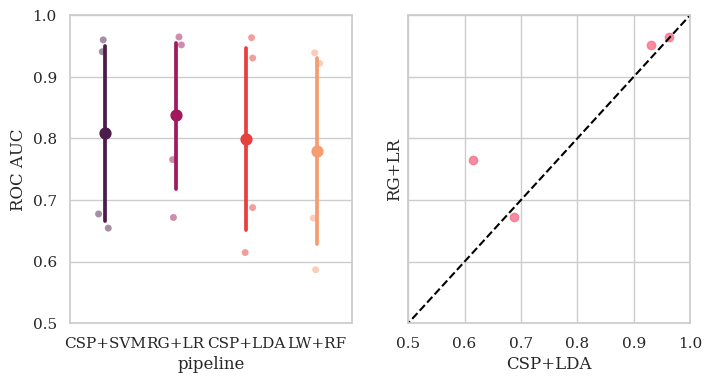

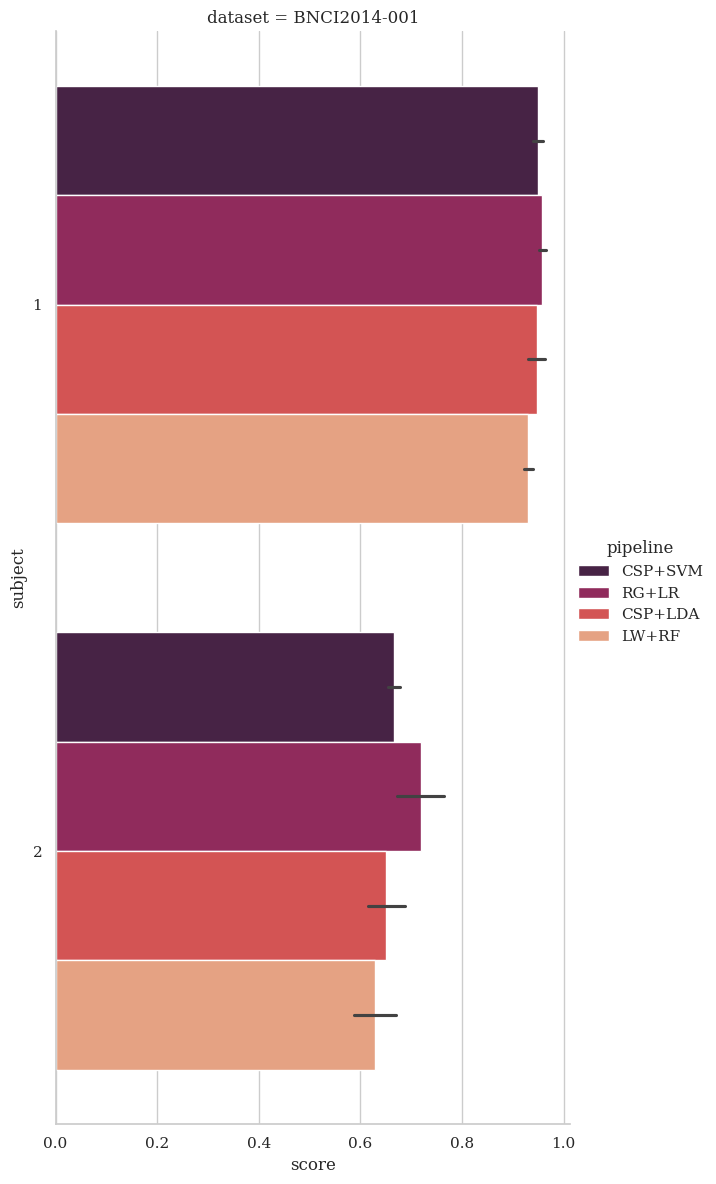

In [ ]:
###### SCRIPT TO PLOT THE RESULTS (do not modify it unless you want to add your framework!) #########

# Plot the global distribution of the performance
fig, axes = plt.subplots(1, 2, figsize=[8, 4], sharey=True)

sns.stripplot(
    data=results,
    y="score",
    x="pipeline",
    ax=axes[0],
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="rocket",
)
sns.pointplot(data=results, y="score", x="pipeline", ax=axes[0], palette="rocket")

axes[0].set_ylabel("ROC AUC")
axes[0].set_ylim(0.5, 1)

paired = results.pivot_table(
    values="score", columns="pipeline", index=["subject", "session"]
)
paired = paired.reset_index()

sns.regplot(data=paired, y="RG+LR", x="CSP+LDA", ax=axes[1], fit_reg=False)
axes[1].plot([0, 1], [0, 1], ls="--", c="k")
axes[1].set_xlim(0.5, 1)

plt.show()

# Plot the individual distribution of the performance
g = sns.catplot(
    kind="bar",
    x="score",
    y="subject",
    hue="pipeline",
    col="dataset",
    height=12,
    aspect=0.5,
    data=results,
    orient="h",
    palette="rocket",
)
plt.show()

----
----
## <b>Part 4 - Experimental considerations</b>

<b>You plan to launch a new protocol based on EEG acquisitions:</b>
- What are the two main types of artifacts you may observe? Please indicate one example for each of them.
- What are the main steps that compose an EEG processing pipeline?

----
Now you are conducting an experimental protocol in BCI.
- It consists in 5 sessions of right hand motor imagery vs rest.
- After the fourth session training sessions subject Y still shows a global performance of 60%.

At each session:
- You instructed the subject to perform a right motor imagery when the visual target was up and to remain at rest when the visual target was down.
- You always selected the same features (power spectra in CP3 at 10Hz & 14Hz, and in C3 at 12Hz & 16Hz).

<b>Based on these elements, what would be your suggestions to help the subject Y improving their performance at session 5?</b>

----
----